In [1]:
#@title Headings

import numpy as np
from scipy.stats import kendalltau
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.ion()

np.set_printoptions(formatter={'float':'{:6.2f}'.format},linewidth=9999)

# Transitive Inference - define Mallows distributions

## Distances



### **Kendall distance**


Kendall distance is based on the proportion of misorderings between two ranking sequences belonging to the complete set of permutations from an initial sequence. It is also called bubble-sort distance since it is equivalent to the number of swaps that the bubble sort algorithm would take to place one list in the same order as the other list.


In [2]:
def kendall(seq1, seq2):

    # Ensure that r1 and r2 have the same length
    assert len(seq1) == len(seq2)

    # ranking sequences
    r1 = np.argsort(seq1).reshape(1, -1)
    r2 = np.argsort(seq2).reshape(1, -1)

    diffs = np.triu(np.sign(r1 - r1.T)*np.sign(r2 - r2.T))
    d = np.sum(diffs<0)

    return d

### **Ulam distance**

The Ulam distance between two permutations of length **n** is the minimum number of insertions and deletions needed to transform one sequence into the other. Equivalently, the Ulam distance is **n** minus the length of the longest common subsequence (LCS) between the permutations

In [3]:
from bisect import bisect_left
def ulam(seq1, seq2):
    n = len(seq1)
    pos = {seq1[i]: i for i in range(n)}
    lis = [0] * n
    length = 0
    for item in seq2:
        if item in pos:
            i = pos[item]
            j = bisect_left(lis, i, 0, length)
            lis[j] = i
            length = max(length, j + 1)
    return n - length

### **Hamming distance**

In [4]:
#@title
def hamming(seq1, seq2):
    seq1 = np.argsort(seq1)
    seq2 = np.argsort(seq2)

    return np.sum(~(seq1 == seq2))

### **Spearman's footrule distance**

In [5]:
def footrule(seq0, seq1):

    # Ensure that r1 and r2 have the same length
    assert len(seq0) == len(seq1)

    n = len(seq0)
    # ranking sequences
    r1 = np.argsort(seq0).reshape(-1, 1)
    r2 = np.argsort(seq1).reshape(-1, 1)

    r2_idcs = np.argwhere(r1 == r2.T).astype(float)
    r1r2_dists = np.subtract(*r2_idcs.T)

    dists = np.abs(r1r2_dists)

    d = np.sum(dists)

    return d



### **Spearman's parametrized**

In [6]:
def footrulegamma(seq0, seq1, gamma=1.2):

    # Ensure that r1 and r2 have the same length
    assert len(seq0) == len(seq1)

    n = len(seq0)
    # ranking sequences
    r1 = np.argsort(seq0).reshape(-1, 1)
    r2 = np.argsort(seq1).reshape(-1, 1)

    r2_idcs = np.argwhere(r1 == r2.T).astype(float)
    r1r2_dists = np.subtract(*r2_idcs.T)

    dists = np.abs(r1r2_dists)**gamma

    d = np.sum(dists)

    return d


### **Spearman's rank correlation distance**

In [7]:
def s2(seq0, seq1):
    # Ensure that r1 and r2 have the same length
    assert len(seq0) == len(seq1)

    n = len(seq0)
    # ranking sequences
    r1 = np.argsort(seq0)
    r2 = np.argsort(seq1)

    return np.sum((r1 - r2)**2)



### **Cayley distance**

In [8]:
def cayley(seq1, seq2):
    seq1 = list(seq1)
    seq2 = list(seq2)
    assert len(seq1) == len(seq2)
    n = len(seq1)
    transpositions = 0
    for i in range(n):
        if seq1[i] != seq2[i]:
            j = seq1.index(seq2[i])
            seq1[i], seq1[j] = seq1[j], seq1[i]
            transpositions += 1
    return transpositions

## Mallows distribution

Distribution of the permutations of a sequence based on a distance between permutations (one of the above):

$$p(\tau_i| \beta, c) \approx  e^{-\beta\ \text{distance}(\tau_i, c)}$$

Distance to be use in the notebook.
choose between:

* **kendall**
* **ulam**
* **hamming**
* **footrule**
* **s2**
* **cayley**

In [9]:
#@title Build functions

def mallows(tau, central, beta, distance=kendall):
    return np.exp(- beta * distance(central, tau))

def mallows_series(beta, n = 6, distance=kendall, central=None, labels=None,):
    if labels is None:
        labels = np.array(['A','B','C','D','E','F'])
    labels = labels[:n]
    if central is None:
        central = np.arange(n)
    perms = np.array(list(permutations(np.arange(n))))
    dists = np.hstack([distance(central, tau) for tau in perms])
    probs = np.hstack([mallows(tau, central, beta=beta, distance=distance) for tau in perms])
    probs = probs/probs.sum()
    return [central, perms, labels, dists, probs]

# Neural Model

## Model description


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.hidden_activation = nn.Sigmoid()
        self.output_activation = nn.Sigmoid()

    def forward(self, x, hidden=False):

        x = self.hidden(x)
        x = self.hidden_activation(x)
        if hidden == True: return x, None
        x = self.output(x)
        x = self.output_activation(x)

        return x

## Sampler

In [11]:
# Define input and target data generator
class Sampler:
    def __init__(self, beta, n, distance):
        self.distance = distance
        # series = (central, perms, labels, dists, probs)
        self.series = mallows_series(beta=beta, n=n, distance=self.distance)
        self.n = n
        self.hovs = np.eye(n)
        self.abs_inputs = self.prepare_inputs(np.arange(self.n))
        self.outs = 1*(np.argmax(self.abs_inputs[:,:n], axis=1) <
                       np.argmax(self.abs_inputs[:,n:], axis=1))
        self.outs = np.vstack([self.outs, 1 - self.outs]).T

        self.data = self.abs_inputs

    def prepare_inputs(self, perm):
        hovsp = self.hovs[perm]
        t = np.arange(self.n)
        inputs_index = np.vstack([x.ravel() for x in np.meshgrid(t, t)][::-1])
        inputs_index = inputs_index[:,inputs_index[0,:] != inputs_index[1,:]]
        inputs = np.hstack([
            hovsp[inputs_index[0]],
            hovsp[inputs_index[1]],
            ])

        return inputs

    def sample_permutation(self):
        central, perms, labels, dists, probs = self.series
        cumprobs = np.hstack([0, np.cumsum(probs)])
        coin = np.random.rand()
        lower = cumprobs[:-1]
        upper = cumprobs[1:]
        perm = perms[np.argwhere((coin > lower) & (coin <= upper))[0][0]]
        return perm

    def get_sample_dataset(self, batch_size):

        inputs = []
        targets = []
        for item in range(batch_size):
            perm = self.sample_permutation()
            inputs.append(self.prepare_inputs(perm))
            targets.append(self.outs[:,:1])

        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        inputs = torch.tensor(inputs, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        inputs = inputs.to(torch_device)
        targets = targets.to(torch_device)

        return inputs, targets

In [12]:
class MixedSampler:

    def __init__(self, beta, ns, distance):
        self.n_tot = np.sum(ns)
        self.ns = ns
        self.samplers = [Sampler(beta, n, distance) for n in ns]

        self.series = [
            np.hstack((
                self.samplers[0].series[0],
                self.ns[0] + self.samplers[1].series[0]
            )),
            None,
            np.array(['A','B','C','D','E','F','G', 'H'])[:self.n_tot]
        ]

        self.samplers[0].data = self.convert_to_full_sequence(
            torch.tensor(self.samplers[0].data, dtype=torch.float32).to(torch_device),
            first=True,
        )

        self.samplers[1].data = self.convert_to_full_sequence(
            torch.tensor(self.samplers[1].data, dtype=torch.float32).to(torch_device),
            first=False,
        )

        cn = 0
        for s in self.samplers:
            s.series[2] = self.series[2][cn:cn + s.n]
            cn += s.n

    def convert_to_full_sequence(self, x, first=None):
        if first == True:
            n = self.n_tot - self.ns[0]
            z = torch.zeros([x.shape[0], n]).to(torch_device)
            x = torch.cat([
                x[:,:n], z, x[:,n:], z,
            ], dim=-1)
        elif first == False:
            n = self.n_tot - self.ns[1]
            z = torch.zeros([x.shape[0], n]).to(torch_device)
            x = torch.cat([
                z, x[:,:n], z, x[:,n:],
            ], dim=-1)
        return x

    def get_sample_dataset(self, batch_size):
        # sample1
        s1inps, s1trgs = self.samplers[0].get_sample_dataset(batch_size//2)
        s2inps, s2trgs = self.samplers[1].get_sample_dataset(batch_size - batch_size//2)

        s1inps = self.convert_to_full_sequence(s1inps, True)
        s2inps = self.convert_to_full_sequence(s2inps, False)

        inputs = torch.cat([s1inps, s2inps])
        targets = torch.cat([s1trgs, s2trgs])

        return inputs, targets


## Training session

In [13]:
def train(model, optimizer, sampler, num_epochs):
    for epoch in range(num_epochs):
        inputs, targets = sampler.get_sample_dataset(items)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        # Print progress
        if epoch%500 == 0 or epoch == num_epochs-1:
            print('Epoch [{}/{}], Loss: {:}'.format(epoch+1, num_epochs, loss.item()))

## Training schedule

In [14]:
from seaborn.categorical import pointplot
from IPython.display import display, clear_output
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from packaging import version

from matplotlib.colors import ListedColormap
# construct cmap
rocket_cmap = ListedColormap(sns.color_palette("rocket", 100).as_hex())
simple_cmap = ["#82A0CB", "#C9896F"]

import sklearn
is_sklearn_120 = version.parse(sklearn.__version__) >= version.parse("1.2.0")

def from_hidden(model, inps):
    if type(inps) == np.ndarray:
        inps = torch.tensor(inps, dtype=torch.float32).to(torch_device)
    h,_ = model.forward(inps, hidden=True)
    h = h.cpu().detach().numpy()
    return h

def test_on_sampler(model, sampler, n=None):

    df = pd.DataFrame()
    if type(sampler) == MixedSampler:
        for s in sampler.samplers:
           cdf = test_on_sampler(model, s, n)
           df = pd.concat([df, cdf])
    else:
        if n is  None: n = sampler.n
        inputs = sampler.data
        if type(inputs) == np.ndarray:
            inputs = torch.tensor(
                inputs, dtype=torch.float32
                ).to(torch_device)

        test_output = model(inputs)
        outputs =  np.hstack([
                inputs.cpu().detach().numpy(),
                test_output.cpu().detach().numpy(),
                ])
        hidden = from_hidden(model, inputs)

        df = pd.DataFrame({
            "fst": [np.argmax(o[:n]) for o in outputs],
            "snd": [np.argmax(o[n:2*n]) for o in outputs],
            "hidden": [h for h in hidden],
            "chc": [o[-1] for o in outputs]
        })

        df.loc[:,["fst", "snd"]] = df.loc[:,["fst", "snd"]].iloc[:] - df.loc[:,["fst", "snd"]].min()
        df["dist"] = df["snd"] - df["fst"]

        df = df.query("dist > 0").sort_values(by=["dist", "fst", "snd"])
        df["pair"] = [f"{sampler.series[2][i]}{sampler.series[2][j]}"
                    for i,j in df[["fst", "snd"]].to_numpy()]
        df["hidden_activation"] = [np.mean(d) for d in df.hidden]

    return df


def analysis(batches, distance, mixed = False):

    # Initialize the MLP model and optimizer
    model = MLP()
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if mixed is False:
        sampler = Sampler(beta, n, distance)
    else:
        sampler = MixedSampler(beta, [n//2, n//2], distance)

    center =  sampler.series[0]
    lbs_items = sampler.series[2][:n]
    print(sampler.series[2])
    lbs = np.vstack([[f"{x}{y}" for y in lbs_items] for x in lbs_items])

    for n_ep in batches:

        train(model, optimizer, sampler, n_ep)
        test_inps = np.hstack((np.eye(n), np.zeros((n, n))))
        h = from_hidden(model, test_inps)

        m = np.linalg.norm(
            h.reshape(1, n, hidden_size) -
            h.reshape(n, 1,hidden_size), axis=2)

        fig, axs = plt.subplots(1, 4,
                                gridspec_kw={
                                    "width_ratios":(1,1,1,2),
                                    "height_ratios":[1],
                                    },
                                figsize=(13, 5))

        ax = axs[0]
        ax.set_aspect(1)
        ax.imshow(m, cmap=rocket_cmap)
        ax.set_xticks(center, labels=lbs_items)
        ax.set_yticks(center, labels=lbs_items)
        ax.set_title("Dissimilarity matrix")

        for i, dimstat in enumerate(["MDS", "PCA"]):

            ax = axs[i+1]
            ax.set_aspect(1)
            ax.set_title(dimstat)

            # analysis
            if dimstat == "MDS":
                if is_sklearn_120:
                    mds = MDS(2, eps=0, normalized_stress='auto', random_state=seed)
                else:
                    mds = MDS(2, eps=0, random_state=seed)
                points = mds.fit_transform(h)
            elif dimstat == "PCA":
                pca = PCA(n_components=2, random_state=seed)
                points = pca.fit_transform(h)

            # plot
            if mixed is True:
                ppoints = [
                    points[:n//2,:],
                    points[n//2:,:],
                ]

                ax.plot(*ppoints[0].T, lw=3, c=simple_cmap[0], zorder=-1)
                ax.plot(*ppoints[1].T, lw=3,  c=simple_cmap[1], zorder=-1)
                ax.scatter(*ppoints[0].T, s=250, lw=3, fc="white", ec=simple_cmap[0], zorder=1)
                ax.scatter(*ppoints[1].T, s=250, lw=3, fc="white", ec=simple_cmap[1], zorder=1)
                for i, (l,p) in enumerate(zip(lbs_items, points)):
                    ax.text(
                        *p,
                        l,
                        va="center",
                        ha="center",
                        color=simple_cmap[0] if i < n//2 else simple_cmap[1],
                        weight="bold",
                    )

            else:
                ax.plot(*points.T, lw=3, c=simple_cmap[0], zorder=-1)
                ax.scatter(*points.T, s=250, lw=3, fc="white", ec=simple_cmap[0], zorder=1)
                for l,p in zip(lbs_items, points):
                    ax.text(
                        *p,
                        l,
                        va="center",
                        ha="center",
                        color=simple_cmap[0],
                        weight="bold",
                    )

            mx = 1.2
            ax.set_xlim(-mx, mx)
            ax.set_ylim(-mx, mx)

        ax = axs[3]
        if mixed is False:
            ax.set_title("Distances")
            df = pd.DataFrame({
                "pair": np.hstack([np.diag(lbs, x) for x in range(1, 6)]),
                "diss": np.hstack([np.diag(m, x) for x in range(1, 6)]),
                "dist": np.hstack([np.ones_like(np.diag(m, x))*x for x in range(1, 6)]),
            })
            p = sns.pointplot(ax=ax, data=df, x="pair", y="diss", hue="dist", palette="rocket")
            ax.get_legend().remove()
            ax.set_xlabel("")
            ax.set_ylabel("")
            rng = df["diss"].max() - df["diss"].min()
            ax.set_aspect(0.5*15/rng)
        else:
            ax.set_axis_off()
            ax.set_aspect(0.1)



        fig.tight_layout()

        plt.close(fig)
        display(fig)

    df = None
    if mixed is True:
        pass
        df = pd.DataFrame()
        for i,s in enumerate(sampler.samplers):
             cdf = test_on_sampler(model, s, n=n)
             cdf["sampler"] = i
             df = pd.concat([df, cdf])
    else:
        df = test_on_sampler(model, sampler, n=n)
        df["sampler"] = 0

    fig1 = plt.figure(figsize=(5, 3.5))
    fig2 = plt.figure(figsize=(5, 3.5))
    ax0 = fig1.add_subplot(111)
    ax1 = fig2.add_subplot(111)


    if mixed == True:
        df["model"] = ["ABC" if x == 0 else "DEF" for x in df["sampler"]]
    else:
        df["model"] = "ABCDEF"

    for p in ['AB', 'BC', 'CD', 'DE', 'EF']:
        if len(df[df.pair.isin([p])]) == 0:
            l = len(df)
            df.loc[l,"pair"] = p
            df.loc[l, "dist"] = 1
            df.loc[l, "sampler"] = 0

    df = df.sort_values(by="pair")

    ax1.set_xticks(np.arange(df["dist"].max()))


    df_dist = df.groupby(["dist", "model"])["chc"].mean().reset_index()
    sns.pointplot(ax=ax0, data=df[df.dist == 1], x="pair", y="chc",
                    hue="model", palette="rocket")
    sns.pointplot(ax=ax1, data=df_dist, x="dist", y="chc",
                    hue="model", palette="rocket")

    ax0.set_xlim(-1, 6)
    ax0.set_ylim(0.7, 0.9)
    ax0.set_yticks([0.75, 1])
    ax0.set_xticks(np.arange(5))
    ax0.set_ylabel("Neural activity")
    ax0.set_xlabel("Serial position")

    ax1.set_ylim(0.7, 1.05)
    ax1.set_xlim(-1, df_dist["dist"].max()*1.5)
    ax1.set_yticks([0.75, 1])
    ax1.set_ylabel("Neural activity")
    ax1.set_xlabel("Simbolic distance")

    plt.close(fig1)
    plt.close(fig2)
    display(fig1)
    display(fig2)

    return h, m, df, model

## Parameters

In [15]:
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

n = 6
# Define MLP parameters
input_size = 2 * n
hidden_size = 30
output_size = 1
learning_rate = 0.0005
items = 100
timing = [500, 2000, 4000, 4000]
#timing = [2000]

## Learning pairwise-ranking choice from a Mixed Mallows model

['A' 'B' 'C' 'D' 'E' 'F']
Epoch [1/2], Loss: 0.2527329921722412
Epoch [2/2], Loss: 0.25250375270843506


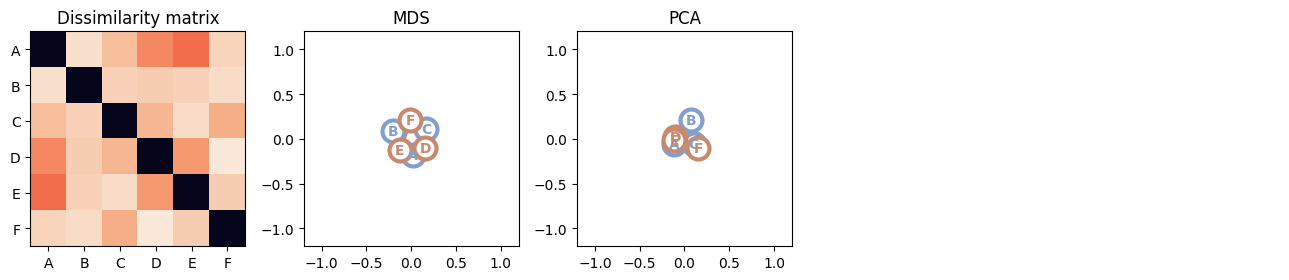

Epoch [1/500], Loss: 0.2520621120929718
Epoch [500/500], Loss: 0.11755182594060898


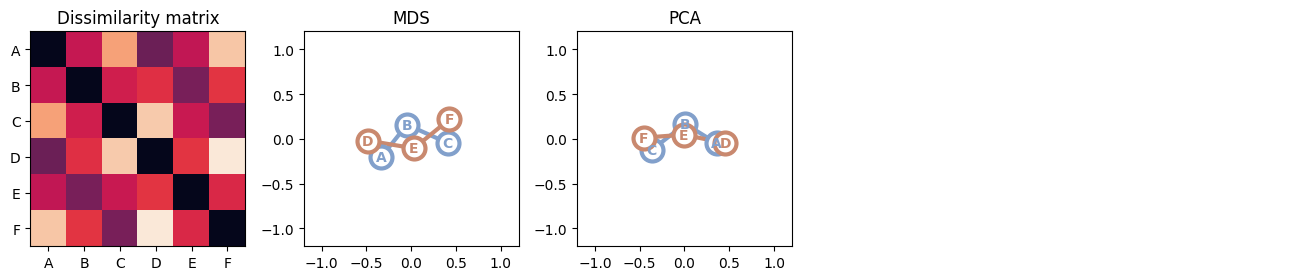

Epoch [1/2000], Loss: 0.14642104506492615
Epoch [501/2000], Loss: 0.07380978763103485
Epoch [1001/2000], Loss: 0.08701442927122116
Epoch [1501/2000], Loss: 0.0636558085680008
Epoch [2000/2000], Loss: 0.09067987650632858


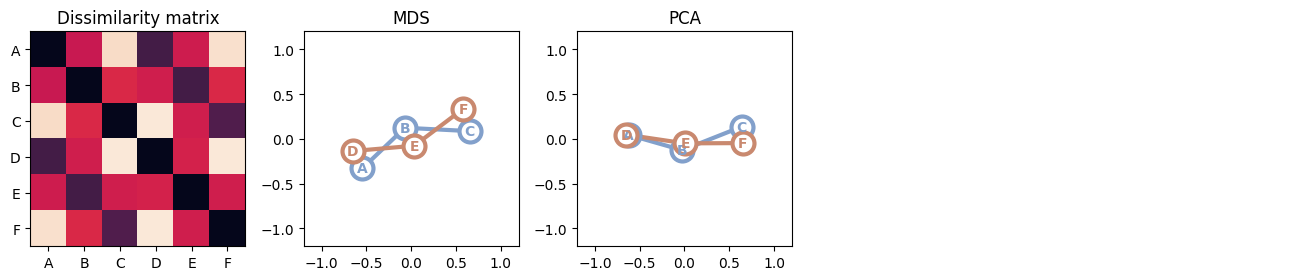

Epoch [1/4000], Loss: 0.09145203977823257
Epoch [501/4000], Loss: 0.10873045772314072
Epoch [1001/4000], Loss: 0.0823674276471138
Epoch [1501/4000], Loss: 0.07278852164745331
Epoch [2001/4000], Loss: 0.11292115598917007
Epoch [2501/4000], Loss: 0.13119187951087952
Epoch [3001/4000], Loss: 0.0993424654006958
Epoch [3501/4000], Loss: 0.09270895272493362
Epoch [4000/4000], Loss: 0.08951791375875473


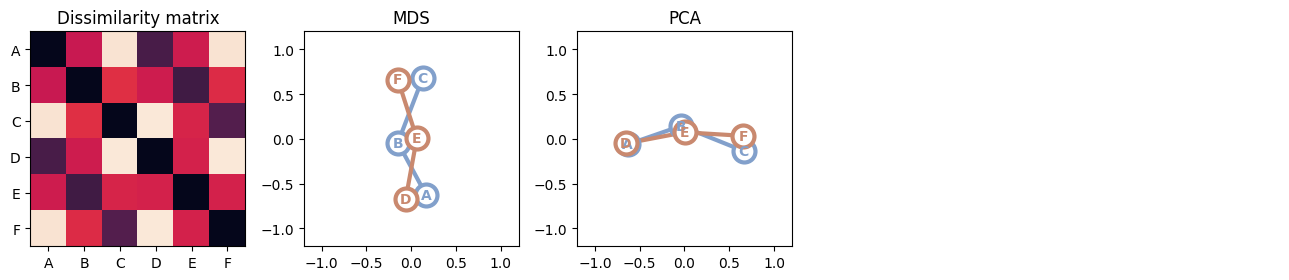

Epoch [1/4000], Loss: 0.08641237765550613
Epoch [501/4000], Loss: 0.0729963406920433
Epoch [1001/4000], Loss: 0.09991031140089035
Epoch [1501/4000], Loss: 0.06324345618486404
Epoch [2001/4000], Loss: 0.10801282525062561
Epoch [2501/4000], Loss: 0.05483390763401985
Epoch [3001/4000], Loss: 0.09376650303602219
Epoch [3501/4000], Loss: 0.12613405287265778
Epoch [4000/4000], Loss: 0.08543454855680466


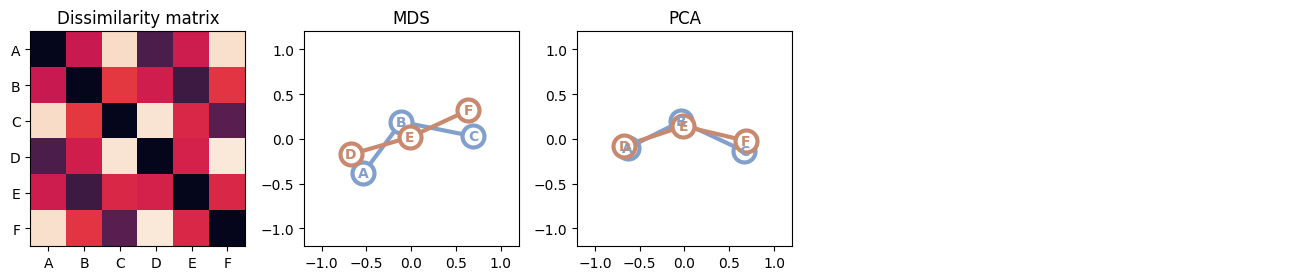

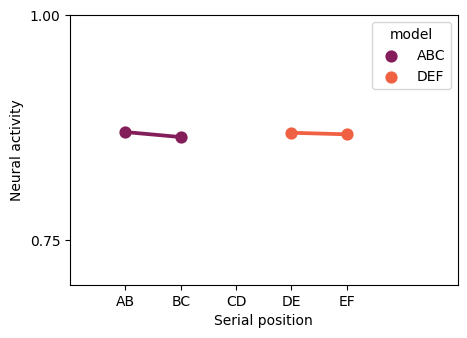

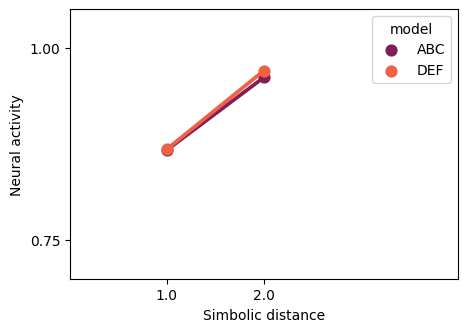

In [16]:
beta=1.15
distance = lambda x, y: footrulegamma(x, y, gamma = .45)
h, m, df, model = analysis([2, *timing], distance, mixed=True)

In [17]:
df

,fst,snd,hidden,chc,dist,pair,hidden_activation,sampler,model
0,0.0,1.0,"[0.43188116, 0.48562655, 0.3509903, 0.6603748,...",0.869955,1.0,AB,0.505014,0.0,ABC
1,0.0,2.0,"[0.39121813, 0.43552542, 0.29635164, 0.7916775...",0.961369,2.0,AC,0.513101,0.0,ABC
3,1.0,2.0,"[0.46425158, 0.43417904, 0.4131854, 0.61666983...",0.864383,1.0,BC,0.497881,0.0,ABC
6,NaN,NaN,NaN,NaN,1.0,CD,NaN,0.0,NaN
0,0.0,1.0,"[0.46317297, 0.49760115, 0.3579731, 0.5943079,...",0.869161,1.0,DE,0.513466,1.0,DEF
1,0.0,2.0,"[0.36178002, 0.6056588, 0.22179152, 0.6800207,...",0.970140,2.0,DF,0.535898,1.0,DEF
3,1.0,2.0,"[0.4925523, 0.5289978, 0.31946844, 0.58911586,...",0.867421,1.0,EF,0.519783,1.0,DEF


## Learning pairwise-ranking choice from a Kendall-based Mallows model

['A' 'B' 'C' 'D' 'E' 'F']
Epoch [1/2], Loss: 0.2558708190917969
Epoch [2/2], Loss: 0.25546377897262573


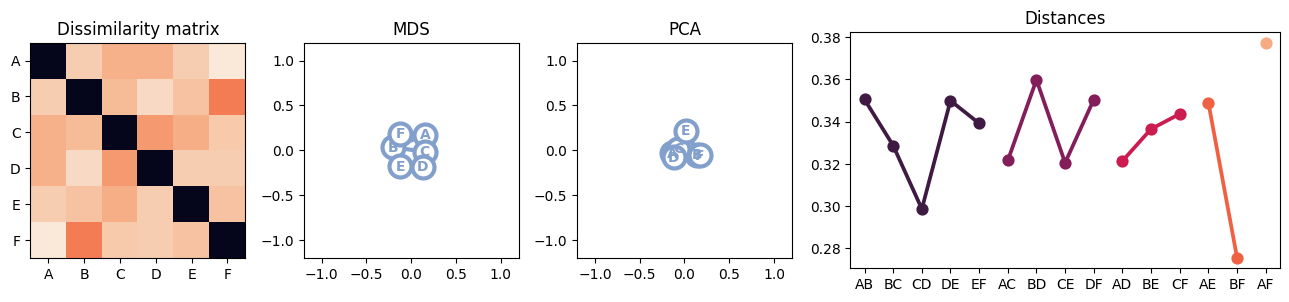

Epoch [1/500], Loss: 0.2552136480808258
Epoch [500/500], Loss: 0.1312026083469391


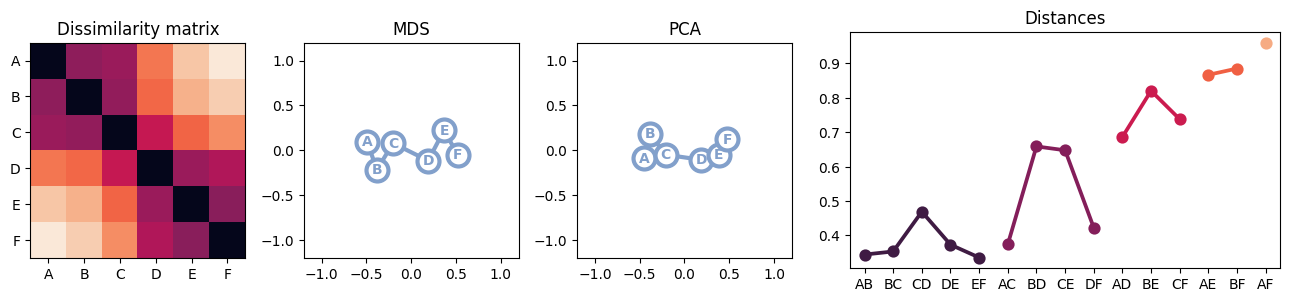

Epoch [1/2000], Loss: 0.13372042775154114
Epoch [501/2000], Loss: 0.07747656106948853
Epoch [1001/2000], Loss: 0.07631665468215942
Epoch [1501/2000], Loss: 0.0649603009223938
Epoch [2000/2000], Loss: 0.06456571817398071


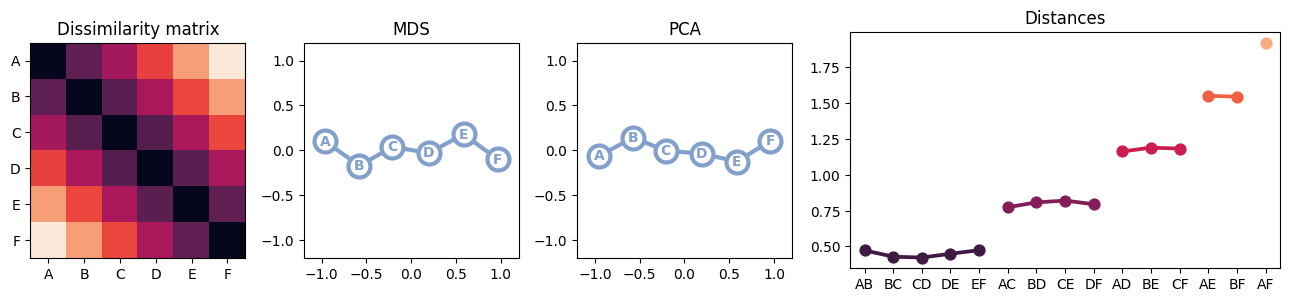

Epoch [1/4000], Loss: 0.06634202599525452
Epoch [501/4000], Loss: 0.06102021783590317
Epoch [1001/4000], Loss: 0.0690196231007576
Epoch [1501/4000], Loss: 0.06087130308151245
Epoch [2001/4000], Loss: 0.07186371088027954
Epoch [2501/4000], Loss: 0.069595567882061
Epoch [3001/4000], Loss: 0.07227344065904617
Epoch [3501/4000], Loss: 0.06222507730126381
Epoch [4000/4000], Loss: 0.060899924486875534


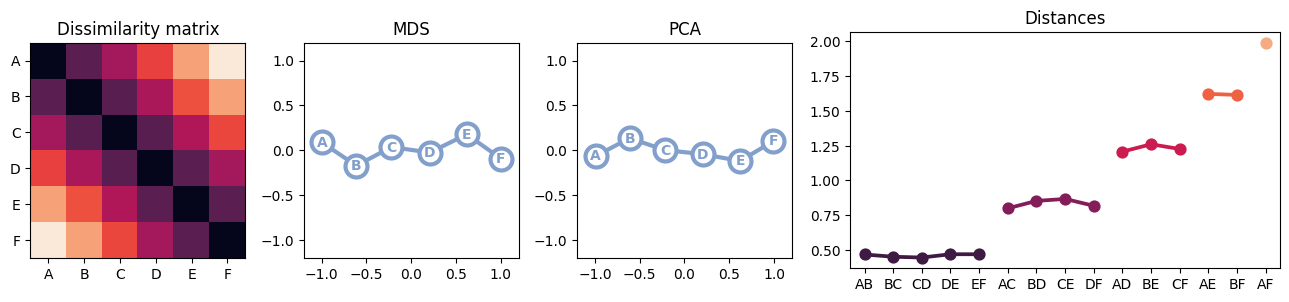

Epoch [1/4000], Loss: 0.06517142802476883
Epoch [501/4000], Loss: 0.06811989098787308
Epoch [1001/4000], Loss: 0.07153841853141785
Epoch [1501/4000], Loss: 0.06990228593349457
Epoch [2001/4000], Loss: 0.06951109319925308
Epoch [2501/4000], Loss: 0.07033916562795639
Epoch [3001/4000], Loss: 0.07745280116796494
Epoch [3501/4000], Loss: 0.06032539904117584
Epoch [4000/4000], Loss: 0.0723610371351242


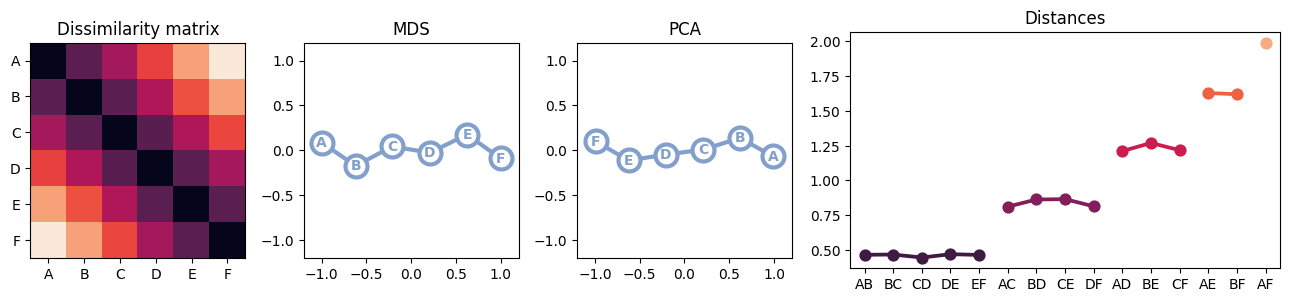

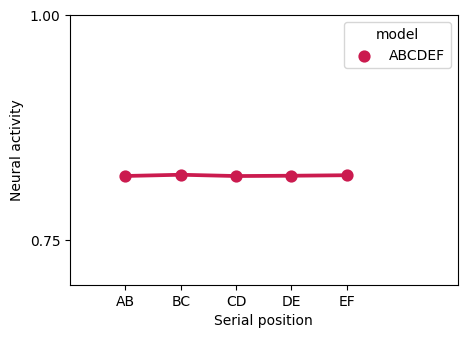

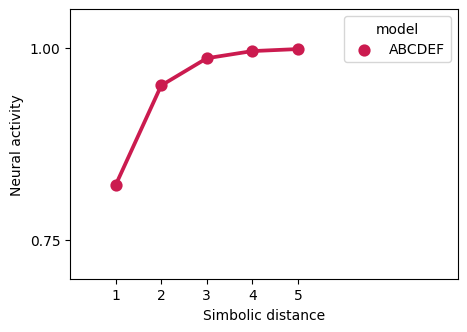

In [18]:
beta=1.6
distance=kendall
h, m, df, model = analysis([2, *timing], distance)

## Learning pairwise-ranking choice from a Footrule-based Mallows model


['A' 'B' 'C' 'D' 'E' 'F']
Epoch [1/2], Loss: 0.2504537105560303
Epoch [2/2], Loss: 0.25033286213874817


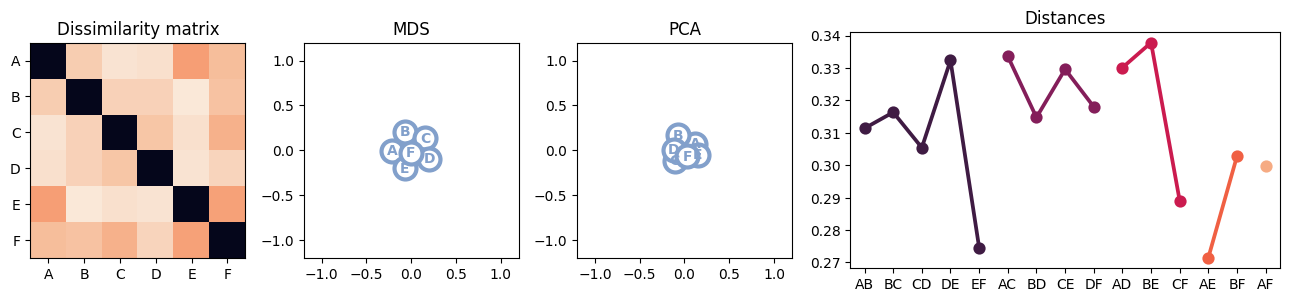

Epoch [1/500], Loss: 0.25016728043556213
Epoch [500/500], Loss: 0.13320082426071167


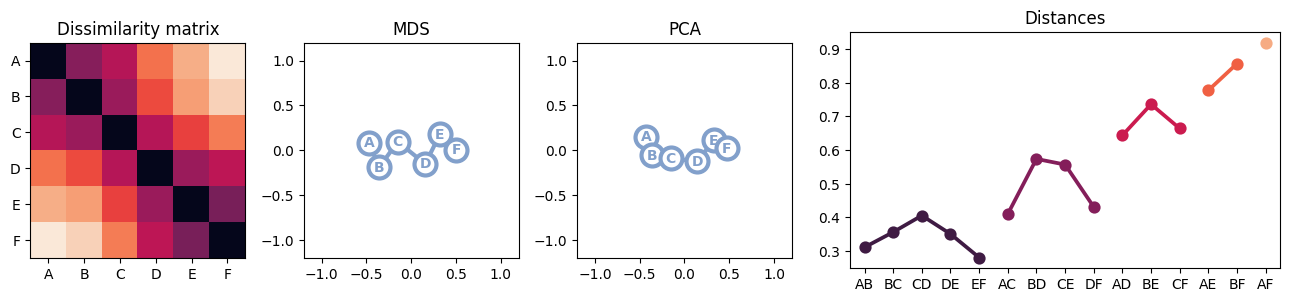

Epoch [1/2000], Loss: 0.12977832555770874
Epoch [501/2000], Loss: 0.09990975260734558
Epoch [1001/2000], Loss: 0.08927327394485474
Epoch [1501/2000], Loss: 0.08595520257949829
Epoch [2000/2000], Loss: 0.09091592580080032


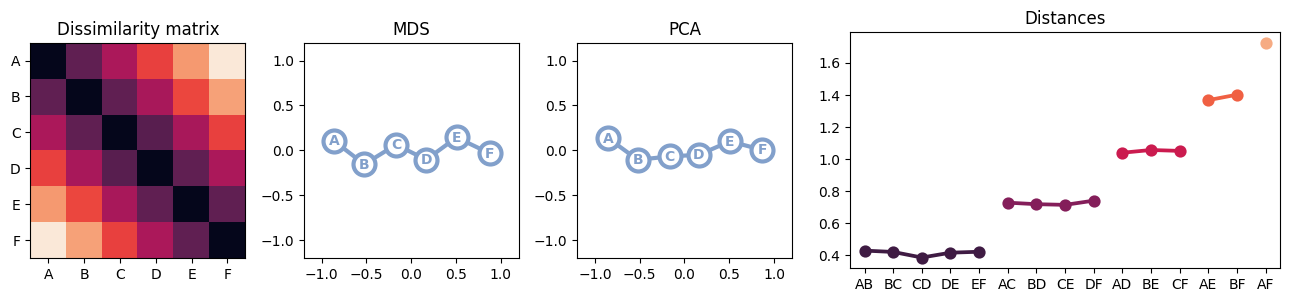

Epoch [1/4000], Loss: 0.08891987055540085
Epoch [501/4000], Loss: 0.08973938226699829
Epoch [1001/4000], Loss: 0.09573008865118027
Epoch [1501/4000], Loss: 0.08818183094263077
Epoch [2001/4000], Loss: 0.08196581155061722
Epoch [2501/4000], Loss: 0.10846435278654099
Epoch [3001/4000], Loss: 0.08215250074863434
Epoch [3501/4000], Loss: 0.08167959004640579
Epoch [4000/4000], Loss: 0.07743342220783234


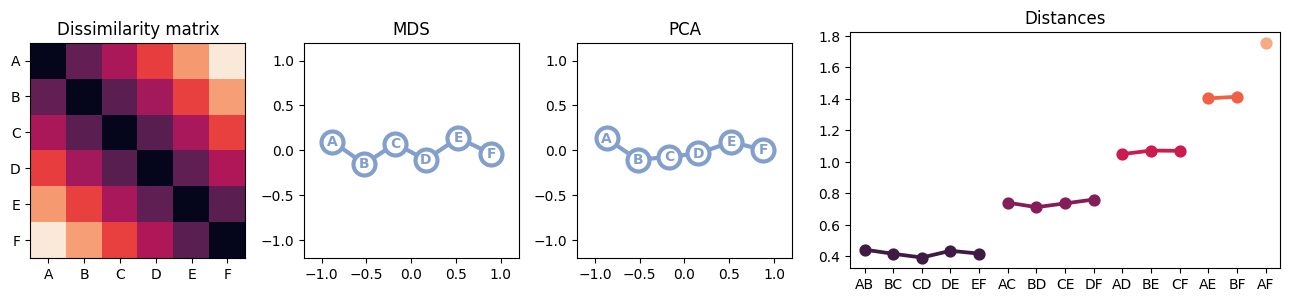

Epoch [1/4000], Loss: 0.07919373363256454
Epoch [501/4000], Loss: 0.08443176746368408
Epoch [1001/4000], Loss: 0.08968711644411087
Epoch [1501/4000], Loss: 0.07849390804767609
Epoch [2001/4000], Loss: 0.07563192397356033
Epoch [2501/4000], Loss: 0.09715836495161057
Epoch [3001/4000], Loss: 0.08713334053754807
Epoch [3501/4000], Loss: 0.07116679102182388
Epoch [4000/4000], Loss: 0.09067289531230927


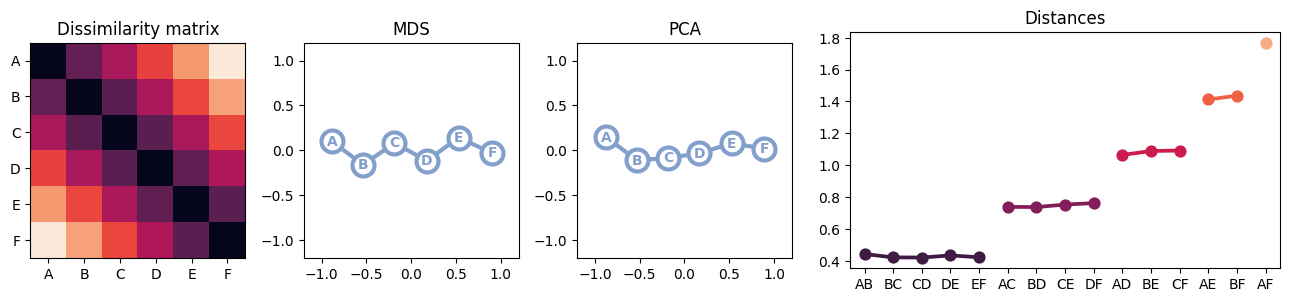

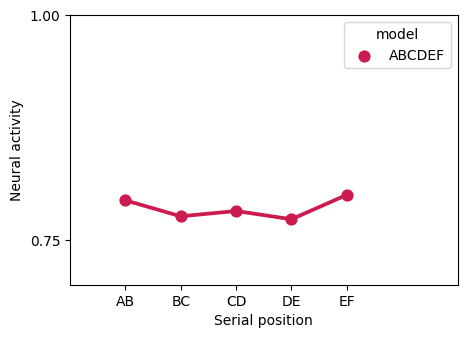

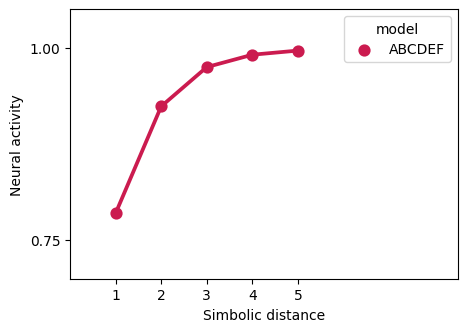

In [19]:
beta=0.8
distance=footrule
h, m, df, model = analysis([2, *timing], distance)

## Learning pairwise-ranking choice from a Parametric-Footrule-based Mallows model

['A' 'B' 'C' 'D' 'E' 'F']
Epoch [1/2], Loss: 0.25025203824043274
Epoch [2/2], Loss: 0.2501714825630188


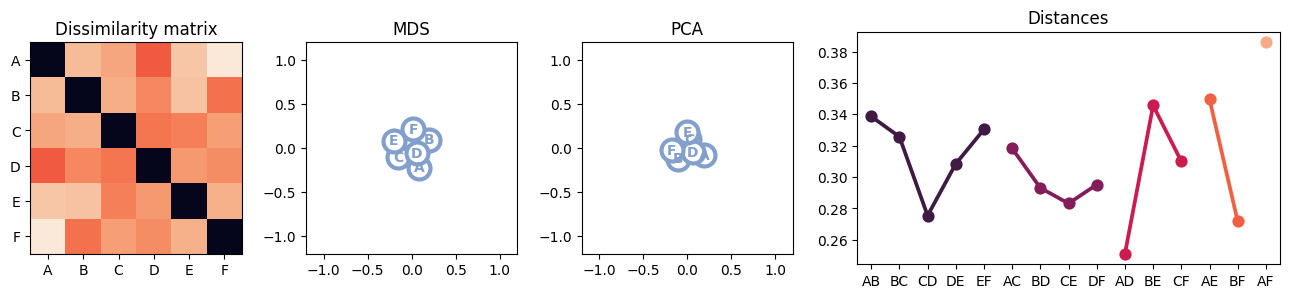

Epoch [1/500], Loss: 0.24996955692768097
Epoch [500/500], Loss: 0.1472415179014206


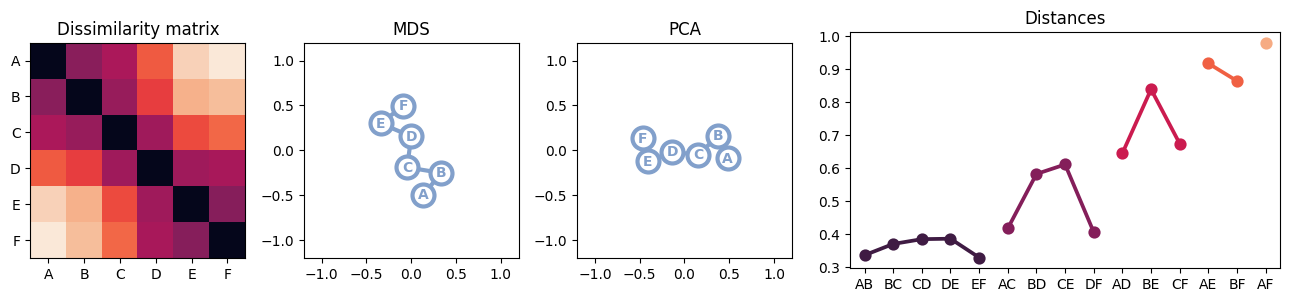

Epoch [1/2000], Loss: 0.1430242657661438
Epoch [501/2000], Loss: 0.12110895663499832
Epoch [1001/2000], Loss: 0.11476900428533554
Epoch [1501/2000], Loss: 0.10732945799827576
Epoch [2000/2000], Loss: 0.10694512724876404


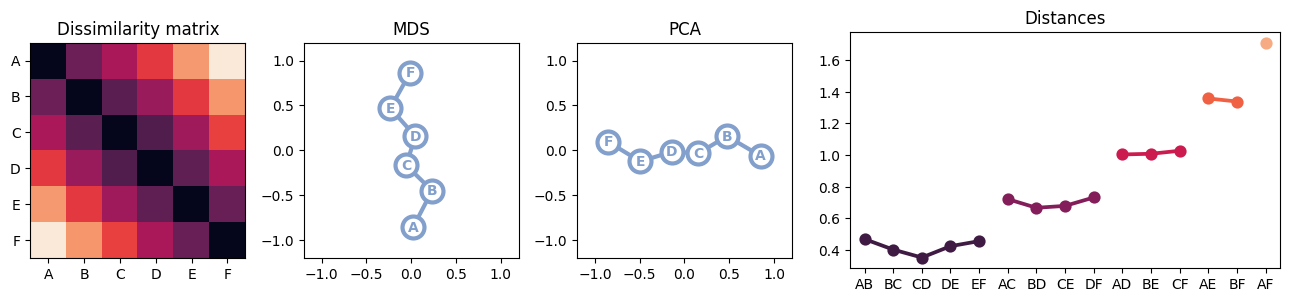

Epoch [1/4000], Loss: 0.1258562058210373
Epoch [501/4000], Loss: 0.1273510605096817
Epoch [1001/4000], Loss: 0.1030983254313469
Epoch [1501/4000], Loss: 0.1106536015868187
Epoch [2001/4000], Loss: 0.13744667172431946
Epoch [2501/4000], Loss: 0.10346187651157379
Epoch [3001/4000], Loss: 0.1319998949766159
Epoch [3501/4000], Loss: 0.11503029614686966
Epoch [4000/4000], Loss: 0.10109875351190567


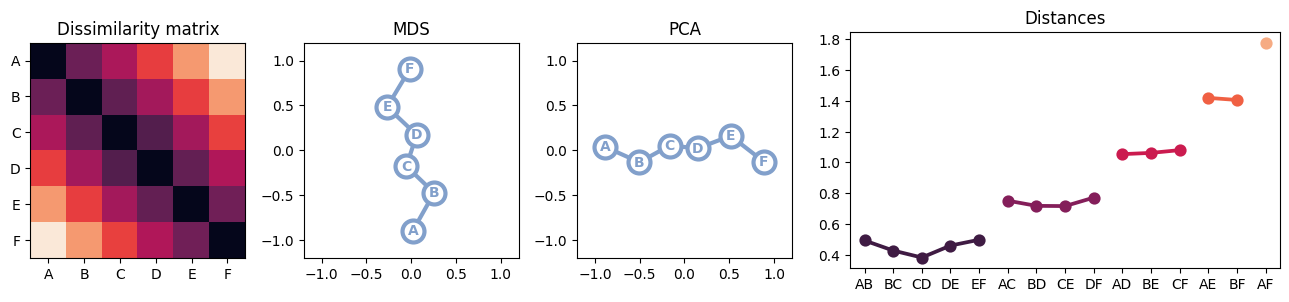

Epoch [1/4000], Loss: 0.10996393114328384
Epoch [501/4000], Loss: 0.10132073611021042
Epoch [1001/4000], Loss: 0.10739413648843765
Epoch [1501/4000], Loss: 0.12414678186178207
Epoch [2001/4000], Loss: 0.11076471954584122
Epoch [2501/4000], Loss: 0.12775614857673645
Epoch [3001/4000], Loss: 0.10862452536821365
Epoch [3501/4000], Loss: 0.10822848230600357
Epoch [4000/4000], Loss: 0.0914921760559082


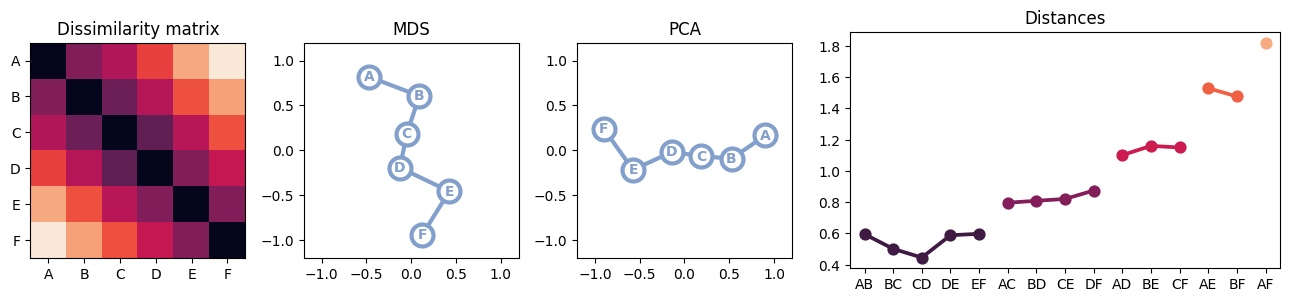

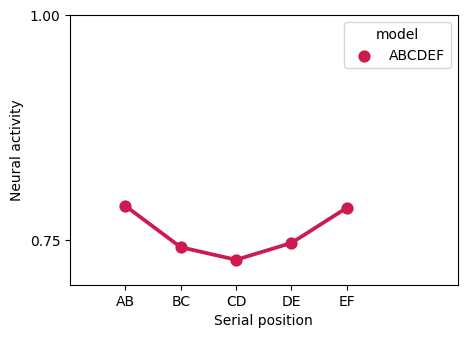

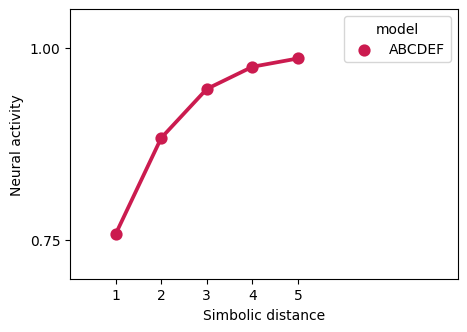

In [20]:
from pandas.core.arrays.timedeltas import timedelta
beta=1.15
distance = lambda x, y: footrulegamma(x, y, gamma = .45)
h, m, df, model = analysis([2, *timing], distance)